## **Praca Domowa 2**
**Autor: Tymoteusz Barciński**

Indywidualnie, zaimplementować model konwolucyjnej sieci neuronowej (CNN) do klasyfikacji w `torch` i przetestować go na **wybranym zbiorze danych**. Powstały raport w formatach `.ipynb` oraz `.html` powinien zawierać wnioski z przeprowadzonej analizy.
1. 1 punkt uzyskuje się za pracę z zbiorem danych [CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)  (60k [take a subset: 1/3-1/2], 10 classes, 32x32 images)<br />
2. ~~2 punkty uzyskuje się za pracę z zbiorem danych [OxfordIIITPet](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html)  (7.4k, 37 classes, varied sizes of images)~~<br />
3. ~~3 punkty uzyskuje się za pracę z zbiorem danych [StanfordCars](https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html) (17k [if too large, take a subset], 196 classes, 360×240 images)~~<br />

- do 2 punktów uzyskuje się za wytrenowanie skutecznego modelu ResNet (porównać dwie wielkości, np. 18 i 34, na zbiorze treningowym i testowym)
- 1 punkt uzyskuje się za zaprezentowanie zwalczania zjawiska przeuczenia wykorzystując Dropout (lub inny sposób regularyzacji)
- ~~1 punkt uzyskuje się za zwizualizowanie macierzy konfuzji ORAZ pokazanie ozasadnionych/ciekawych przykłady obrazów, na których model się mylił~~
- ~~1 punkt uzyskuje się za zwizualizowanie wektora reprezentacji obrazów w podziale na klasy (kolor), wykorzystując PCA/TSNE (lub inny algorytm redukcji wymiaru)~~
- do 2 punktów uzyskuje sie za jakość raportu (opisu, wizualizacji, kodu), a w szczególności *agregację wyników* w postaci tabel lub/i wykresów.

**Uwaga!** (1) Zabronione jest importowanie modeli z bibliotek; można korzystać z repozytoriów takich jak https://github.com/kuangliu/pytorch-cifar. (2) Warto zacząć od uczenia sieci na podzbiorze, np. 10%, danych treningowych (i ewaluowania na podzbiorze danych testowych) dla zaoszczędzenia czasu. 

Praca domowa jest na 8 punktów (można uzyskać max 10 punktów).

Deadline: 30 marca 23:59. Na zajęciach 31 marca 5 wybranch osób krótko zaprezentuje swoje wyniki.

Pracę zgłaszamy poprzez PR o tytule `[PD2] Imię Nazwisko` do folderu `homeworks/pd2/imię_nazwisko`.

## Ładowanie bibliotek

In [3]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F # korzystanie z API functional
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import numpy as np
import seaborn as sns
import tqdm 
import json
from IPython.display import clear_output
from collections  import OrderedDict
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from torch.utils.tensorboard import SummaryWriter

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [4]:
torch.cuda.is_available()

if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu" 

In [5]:
torch.manual_seed(1)
np.random.seed(1)

## Ładowanie danych

In [6]:
train_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()])
)
test_set = torchvision.datasets.CIFAR10(
    root = './data/CIFAR10', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


## Architektura sieci neuronowej
źródło: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
  
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    return y

## Funkcja ucząca
źródło: https://github.com/MI2-Education/2022L-WB-XIC/blob/main/labs/lab3/code.ipynb

In [8]:
def training_function(net, learning_rate, batch_size, num_iter, training_set, testing_set, percent_of_data):

  # preparing data
  list_train = list(np.random.randint(0, len(training_set), int(percent_of_data*0.01*len(training_set))))
  list_test = list(np.random.randint(0, len(testing_set), int(percent_of_data*0.01*len(testing_set))))

  train_subset = torch.utils.data.Subset(training_set, list_train)
  test_subset = torch.utils.data.Subset(testing_set, list_test)

  dataloader_train_set = torch.utils.data.DataLoader(train_subset, batch_size, shuffle=True, num_workers=2)
  dataloader_test_set = torch.utils.data.DataLoader(test_subset, batch_size, shuffle=True, num_workers=2)

  losses = []
  errors_train = []
  errors_test = []

  if net == "ResNet18":
    net = ResNet18()
  else:
    net = ResNet34()

  network = net.to(DEVICE)

  loss = torch.nn.CrossEntropyLoss(reduction='none')              
  optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

  for epoch in tqdm.tqdm(range(num_iter)):
      losses_iter = []
      errors_train_iter = []
      errors_test_iter = []
      
      for X, y in dataloader_test_set:
          X_cuda = X.to(DEVICE)
          y_cuda = y.to(DEVICE)
          y_hat = net(X_cuda)                                                          
          errors_test_iter += [(y_cuda != y_hat.argmax(1)).float().mean().item()]     

      for X, y in dataloader_train_set:
          X_cuda = X.to(DEVICE)
          y_cuda = y.to(DEVICE)
          y_hat = net(X_cuda)                                                          
          errors_train_iter += [(y_cuda != y_hat.argmax(1)).float().mean().item()]    
          l = loss(y_hat, y_cuda)                                                     
          optimizer.zero_grad()                                                   
          l.mean().backward()                                                     
          losses_iter += [l.mean().item()]                                       
          optimizer.step()                                                        
      
      errors_train += [np.mean(errors_train_iter)]
      errors_test += [np.mean(errors_test_iter)]
      losses += [np.mean(losses_iter)]

  return errors_train, errors_test

In [9]:
def generate_plot(errors_train, errors_test):
  num_iter = len(errors_train)
  plt.figure(figsize=(12, 8))
  plt.plot(range(num_iter), errors_train)
  plt.plot(range(num_iter), errors_test)
  plt.title("Learning curves")
  plt.legend(['Error_train', 'Error_test', 'Loss'])
  plt.show()

## Badanie hiperparametrów, ResNet18 vs ResNet34

In [10]:
results = pd.DataFrame({'run': [],
                        'epoch':[],
                        'percent_of_data': [],
                        'net': [],
                        'learning_rate':[],
                        'batch_size': [],
                        'training_accuracy':[],
                        'test_accuracy':[]})
epchos = 5
run = 1
percent = 20
for net in ["ResNet18", "ResNet34"]:
      for bs in [128, 256]:
          for lr in [0.1, 0.01]:
                  errors_train, errors_test = training_function(net, learning_rate=lr, batch_size=bs,
                                                                        num_iter=epchos, training_set = train_set, testing_set = test_set, percent_of_data = percent)
                  for epoch in range(len(errors_train)):
                      new_result = ({'run': run,
                                   'epoch': epoch + 1,
                                   'percent_of_data': percent,
                                  'net': net,
                                  'learning_rate':lr,
                                  'batch_size': bs,
                                  'training_accuracy':1-errors_train[epoch],
                                  'test_accuracy':1-errors_test[epoch]})
                      results = results.append(new_result, ignore_index=True)
                  run += 1

100%|██████████| 5/5 [05:01<00:00, 60.21s/it]


In [12]:
results.sort_values(by = "test_accuracy", ascending = False).head(10)

,run,epoch,percent_of_data,net,learning_rate,batch_size,training_accuracy,test_accuracy
9,2.0,5.0,20.0,ResNet18,0.01,128.0,0.712322,0.482324
29,6.0,5.0,20.0,ResNet34,0.01,128.0,0.696203,0.467383
8,2.0,4.0,20.0,ResNet18,0.01,128.0,0.628165,0.424902
27,6.0,3.0,20.0,ResNet34,0.01,128.0,0.526206,0.374121
18,4.0,4.0,20.0,ResNet18,0.01,256.0,0.537891,0.367112
24,5.0,5.0,20.0,ResNet34,0.10,128.0,0.527888,0.363281
19,4.0,5.0,20.0,ResNet18,0.01,256.0,0.590723,0.359488
17,4.0,3.0,20.0,ResNet18,0.01,256.0,0.483301,0.356971
38,8.0,4.0,20.0,ResNet34,0.01,256.0,0.512500,0.354530
6,2.0,2.0,20.0,ResNet18,0.01,128.0,0.457773,0.340820


### Wnioski:
* nie ma znaczącej różnicy pomiędzy pomiędzy sieciemi ResNet18 i ResNet34 pod kątem accuracy na zbiorze testowym.
* Sieci z mniejszym batch sizem osiągały lepsze wyniki zarówno na zbiorze treningowym jak i testowym.
* widać wyraźnie, że powyższe modele overfitują.
* Mniejszy leraning rate sokutkuje lepszymi wynikomami na zbiorze testowym.
* warto zaznaczyć, że zarówno powyższe modele jak i analiza jest mocno ograniczona z powodu wykorzystywania jedynie 20% danych ze względów wydajnościowych.

## Podejście na całych danych


In [ ]:
errors_train, errors_test = training_function(net = "ResNet18", learning_rate = 0.01, batch_size = 512, num_iter = 12,
                                                        training_set = train_set, testing_set = test_set, percent_of_data = 100)

In [ ]:
errors_test[-1]

0.38569048792123795

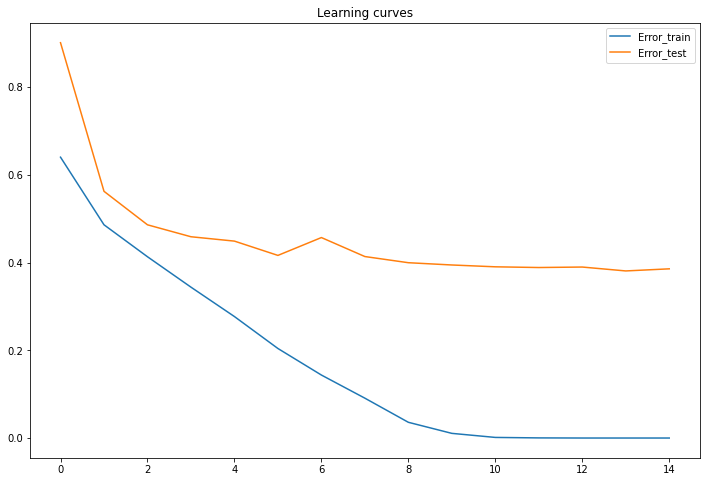

In [ ]:
generate_plot(errors_train, errors_test)

### Wnioski:
* widać wyraźnie, że sieć jest podantna na overfitting.
* błąd na zbiorze testowym ustabiliozwał się w okolicach 8 epoki
* uczenie siecie na całości danych zwiększyło accuracy do poziomu około 62% jednak nadal, jest to wynik daleki od satysfakcjonującego.

## Dropout
źródło: https://discuss.pytorch.org/t/where-and-how-to-add-dropout-in-resnet18/12869

In [ ]:
net_2 = ResNet18()
dropout_rate = 0.5

def append_dropout(model, rate=dropout_rate):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=True))
            setattr(model, name, new)

append_dropout(net_2)

In [ ]:
errors_train, errors_test = training_function(net_2, learning_rate=0.01, batch_size=512, num_iter=10, training_set = train_set,
                                              testing_set = test_set, percent_of_data = 100)

In [ ]:
errors_test[-1]

0.4325912318059376

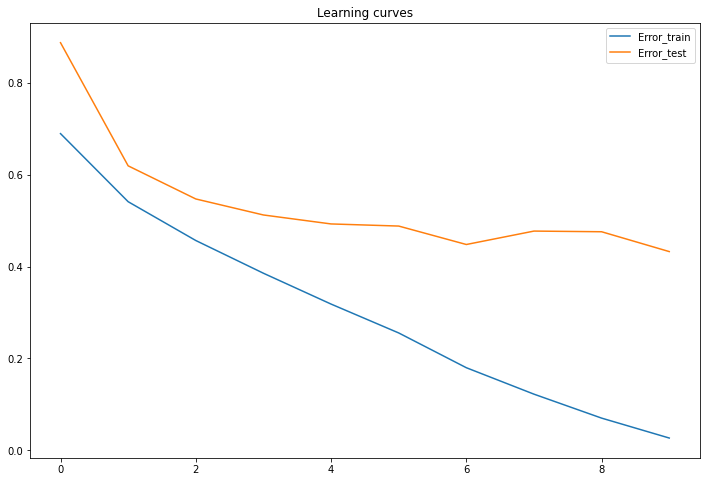

In [ ]:
generate_plot(errors_train, errors_test)

**Wniosek**: wprowadzenie dropout na poziomie 0.5 nie wpływa pozytywnie na proces uczenia się sieci. Liczba epok została ograniczona do 10 ze wzlędu na stabilizacje procesu uczenia w okolicach 8 epoki dla poprzedniego modelu.